# Modeling

## Imports and Settings

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

import os

import sys
sys.path.append("..") # go to parent dir

from utils.currency_functions import league_df, trade_ratio, average_ratio, league_day

In [2]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [3]:
# List of the Currencies we will be studying.
currencies = ["Hunter's Exalted Orb", "Crusader's Exalted Orb", "Redeemer's Exalted Orb", "Warlord's Exalted Orb", "Awakener's Orb"]

In [4]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    '''
    This function takes the output of a adfuller test function and returns it as a pandas series.
    
    dftest: adfuller() function output.
    '''
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [5]:
def currency_dftest(currency, diffs=0):
    '''
    This function takes the adfuller test results for all leagues for a specified currency and stores them as
    a pandas dataframe.
    
    currency: specified currency
    diffs: default=0. differences to be tested.
    '''
    path = '../leagues/'
    result_df = pd.DataFrame()
    
    for league in os.listdir(path):
        df = league_df(league, currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        
        if diffs>0:
            for i in range(0, diffs):
                df['Ratio'] = df['Ratio'].diff()
            df.dropna(inplace = True)
        
        adftest = interpret_dftest(adfuller(df['Ratio']))
        
        result_to_add = pd.DataFrame({
            'League': [league],
            'Currency': [currency],
            'Diff': [diffs],
            'Test Statistic': [adftest['Test Statistic']],
            'p-value': [adftest['p-value']]
        })
        result_df = pd.concat([result_df, result_to_add], ignore_index=True)
    
    return result_df

Using the two functions above, we can create a dataframe with all the p-values for all of the leauge-currency-differencing combinations. We can use this later to determine with differencing value we should set for our ARIMA models.

In [6]:
test_df = pd.DataFrame()

for currency in currencies:
    for i in range(0, 3):
        diffs = i
        test_df_add = currency_dftest(currency, diffs=diffs)
        test_df = pd.concat([test_df, test_df_add], ignore_index=True)
        
test_df

,League,Currency,Diff,Test Statistic,p-value
0,Sanctum,Hunter's Exalted Orb,0,-9.699851,1.079497e-16
1,Heist,Hunter's Exalted Orb,0,-1.348307,6.067927e-01
2,Metamorph,Hunter's Exalted Orb,0,-2.306097,1.700092e-01
3,Kalandra,Hunter's Exalted Orb,0,-1.876077,3.433978e-01
4,Harvest,Hunter's Exalted Orb,0,-0.914264,7.832386e-01
...,...,...,...,...,...
175,Ultimatum,Awakener's Orb,2,-5.863421,3.368672e-07
176,Archnemesis,Awakener's Orb,2,-5.054443,1.729803e-05
177,Expedition,Awakener's Orb,2,-7.404416,7.409263e-11
178,Scourge,Awakener's Orb,2,-6.113566,9.208689e-08


In [7]:
def currency_train_test_split(df):
    '''
    This function takes a dataframe, and returns the train test split for the dataset, using the last 10 days for the test split.
    '''
    y = df['Ratio']
    y_train = y[:-10]
    y_test = y[-10:]
    return y_train, y_test

In [8]:
def manual_grid_search(y_train, p_range=5, q_range=5, diffs=0):
    '''
    This is a modified manual grid search from my DSI course. It's been modified to work as a function.
    
    y_train: The training split.
    p_range: The range of values that you want to gridsearch over for p.
    q_range: The range of values that you want to gridsearch over for q.
    diffs: The differencing mean to be done on the model.
    '''
    # Starting AIC, p, and q.
    best_aic = 999999999
    best_p = 0
    best_q = 0
    
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range):
        for q in range(q_range):
            
            # Insert try and except statements.
            try:
                
                # Instantiate ARIMA model.
                arima = ARIMA(endog = y_train, order = (p, diffs, q))
                
                # Fit ARIMA model.
                model = arima.fit()
   
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:
                    
                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
    
            except:
                pass
    print()
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
    print(f'This model has an AIC of {best_aic}.')
    return best_p, best_q

In [9]:
def arima_model(y_train, p, d, q):
    '''
    This function takes the parameters for an Arima model and fits one.
    
    y_train: train split.
    p: The value of P for the ARIMA model.
    d: The value of D for the ARIMA model.
    q: The value of Q for the ARIMA model.
    '''
    arima = ARIMA(endog = y_train, order = (p, d, q))
    
    model = arima.fit()
    
    return model

In [10]:
def arima_preds(model, y_test):
    '''
    This function gets predictions from an inputed model.
    
    model: ARIMA model to get predictions from.
    y_test: The test split to get the index from.
    '''
    # Get forecast steps from the model.
    preds = model.get_forecast(steps=len(y_test))
    
    # Extract the predicted mean for these steps.
    preds_mean = preds.predicted_mean

    return preds_mean

In [11]:
def plot_preds(y_train, y_test, preds, p, d, q, league, currency):
    '''
    This function takes the train, test, and prediction sets and plots them all on one graph.
    
    y_train: train set.
    y_test: test set.
    preds: predictions set.
    p: P for ARIMA model
    d: D for ARIMA model
    q: Q for ARIMA model
    league: League that the model was for.
    currency: Currency that the model was for.
    '''
    plt.figure(figsize=(10,6))
    
    color1 = load_color("mocha", "blue")
    color2 = load_color("mocha", "yellow")
    color3 = load_color("mocha", "green")
    
    plt.plot(
        y_train.index, 
        y_train, 
        color = color1,
        label = 'Train'
    )
    
    plt.plot(
        y_test.index, 
        y_test, 
        color = color2,
        label = 'test'
    )
    
    plt.plot(
        y_test.index, 
        preds, 
        color = color3,
        label = 'preds'
    )
    
    plt.title(label = f'{league} {currency} ARIMA({p}, {d}, {q}) Predictions', fontsize=16)
    plt.legend()
    plt.savefig(f'../images/arima_{currency}_{league}.png')
    plt.show();

In [12]:
def full_model_proccess(currency):
    '''
    This function takes all the functions from above and aggregates them into one function. This allows us to just input the currency we want to check
    and we run that currency through all the steps for each league to get an ARIMA model made and graphed.
    
    currency: currency to be modeled.
    '''
    path = '../leagues/'
    for league in os.listdir(path):
        df = league_df(league=league, currency=currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        
        y_train, y_test = currency_train_test_split(df)
        
        threshold = 0.05
        filtered_df = test_df[(test_df['League'] == league) & (test_df['Currency'] == currency)]
        sorted_df = filtered_df.sort_values('p-value', ascending=True)
        first_below_threshold = sorted_df[sorted_df['p-value'] < threshold].iloc[0]
        
        if not first_below_threshold.empty:
            diff = first_below_threshold['Diff']
        else:
            print('No p-value below the threshold')
            continue
    
        p, q = manual_grid_search(y_train, p_range=5, q_range=5, diffs=diff)
        
        model = arima_model(y_train, p=p, d=diff, q=q)
        
        preds = arima_preds(model, y_test)
        print(f'The Mean Absolute Error is {mean_absolute_error(y_test, preds)}')
        print(f'The Mean Squared Error is {mean_squared_error(y_test, preds)}')
        
        plot_preds(y_train, y_test, preds=preds, p=p, d=diff, q=q, league=league, currency=currency)


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 757.1731327538026.
The Mean Absolute Error is 2.5801620845483852
The Mean Squared Error is 16.42232662934733


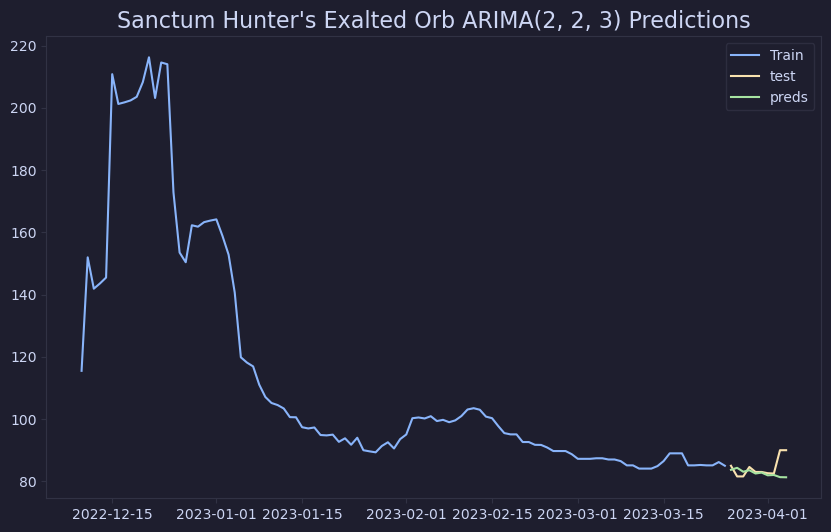


Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 757.5210053195472.
The Mean Absolute Error is 12.914626026576949
The Mean Squared Error is 317.15624296542956


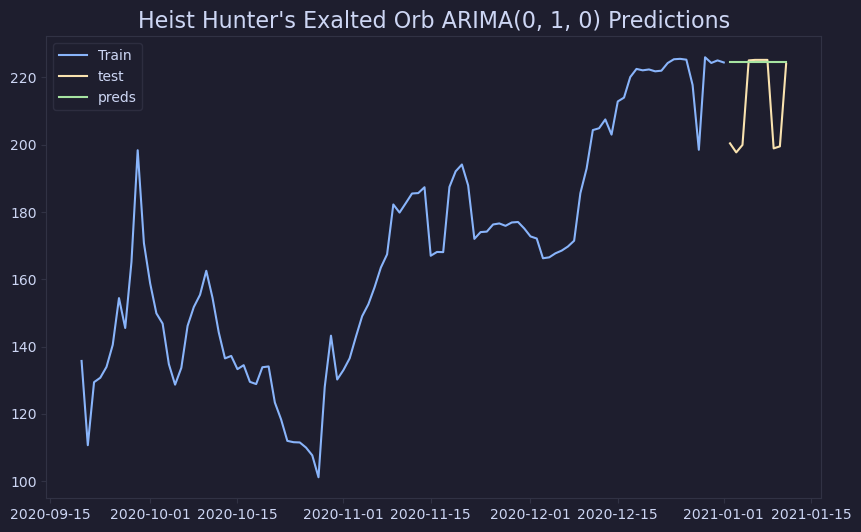


Our model that minimizes AIC on the training data is the ARIMA(1,1,4).
This model has an AIC of 752.0362987067227.
The Mean Absolute Error is 163.72772885309638
The Mean Squared Error is 28286.57463647541


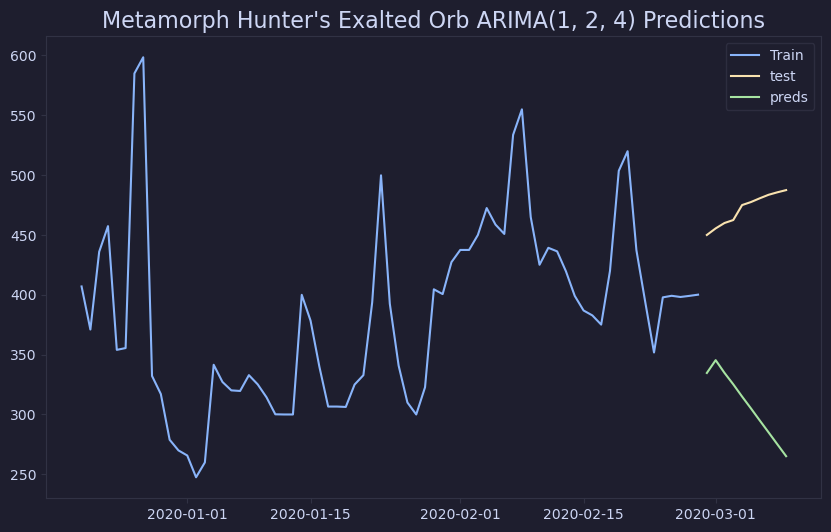


Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 715.4376460887603.
The Mean Absolute Error is 6.751288695139427
The Mean Squared Error is 62.88373816723102


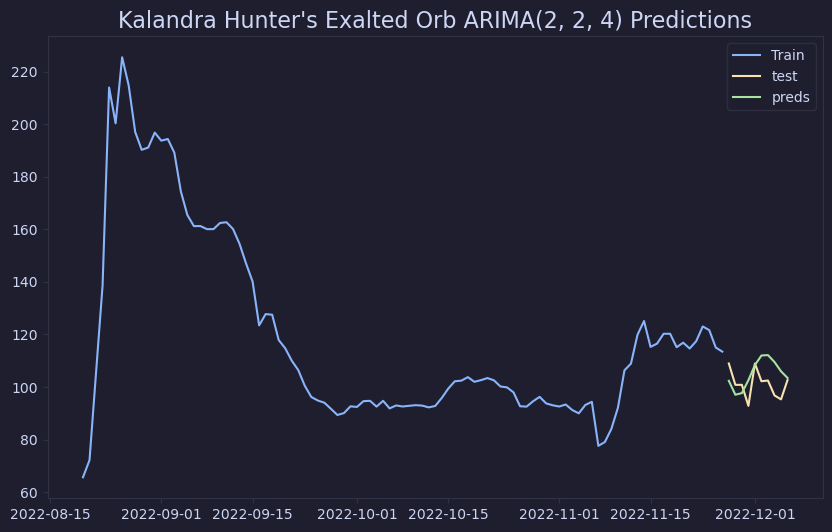


Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 730.0393304422512.
The Mean Absolute Error is 14.833324577991451
The Mean Squared Error is 334.22069811807734


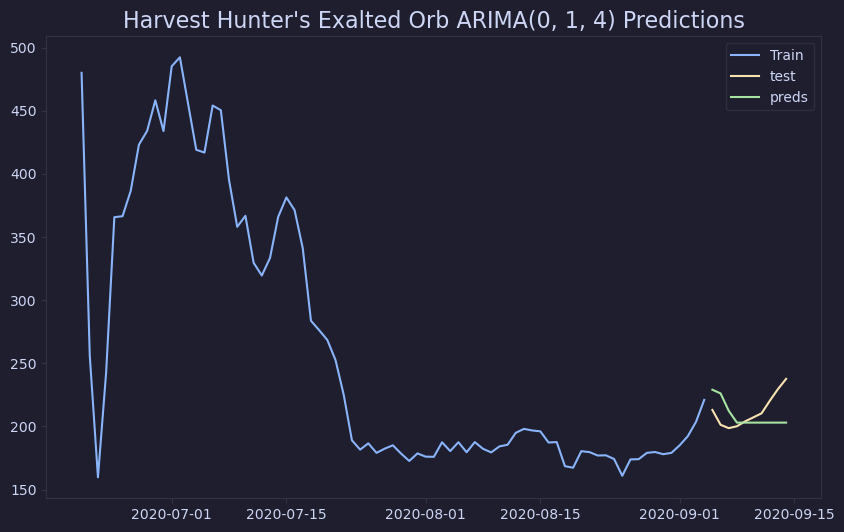


Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 639.5259423493942.
The Mean Absolute Error is 51.865115905882384
The Mean Squared Error is 2902.5304887575394


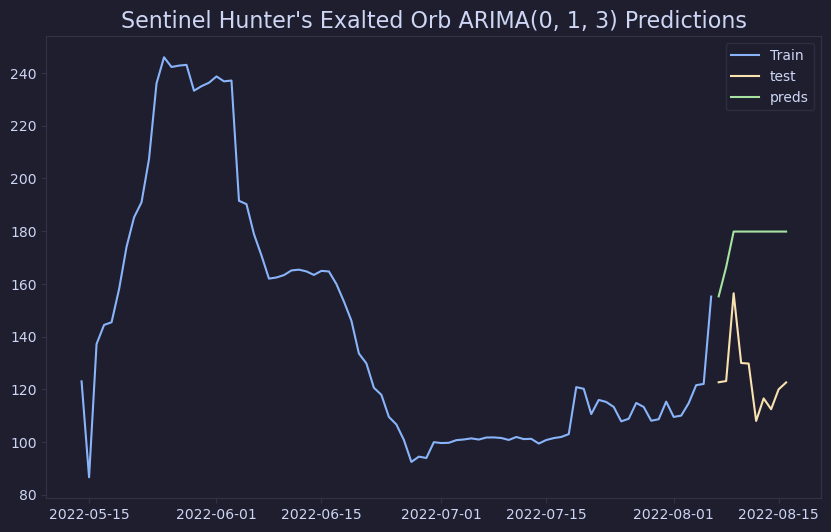


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 778.4466506367439.
The Mean Absolute Error is 7.8064829795373525
The Mean Squared Error is 148.1443238564155


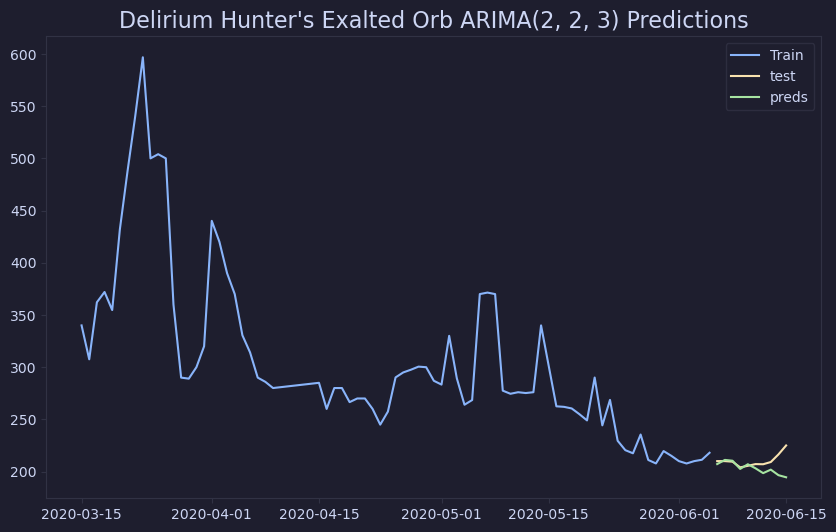


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 649.4279340704669.
The Mean Absolute Error is 4.6776660581807
The Mean Squared Error is 31.49674260176019


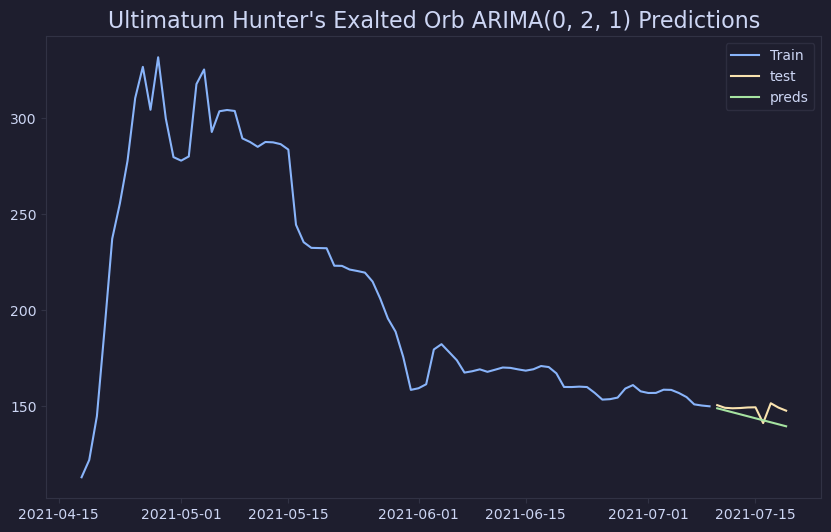


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 694.8771301001655.
The Mean Absolute Error is 15.945561204679786
The Mean Squared Error is 403.4481093726308


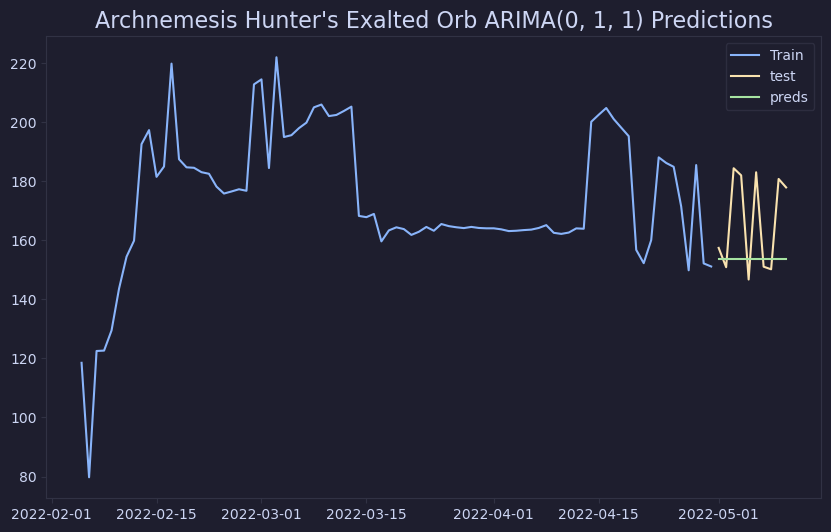


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 722.1069329967039.
The Mean Absolute Error is 31.815431049488087
The Mean Squared Error is 2121.0341377766586


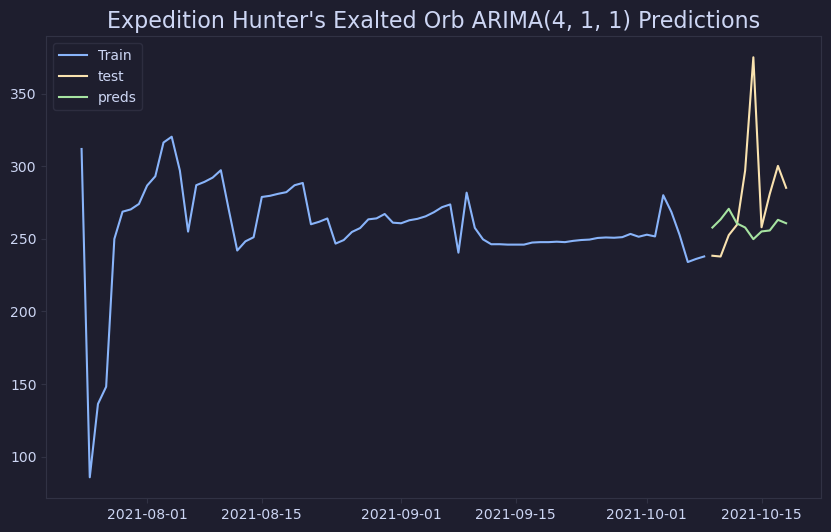


Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 669.7305130357963.
The Mean Absolute Error is 13.731445723869822
The Mean Squared Error is 345.81175513509885


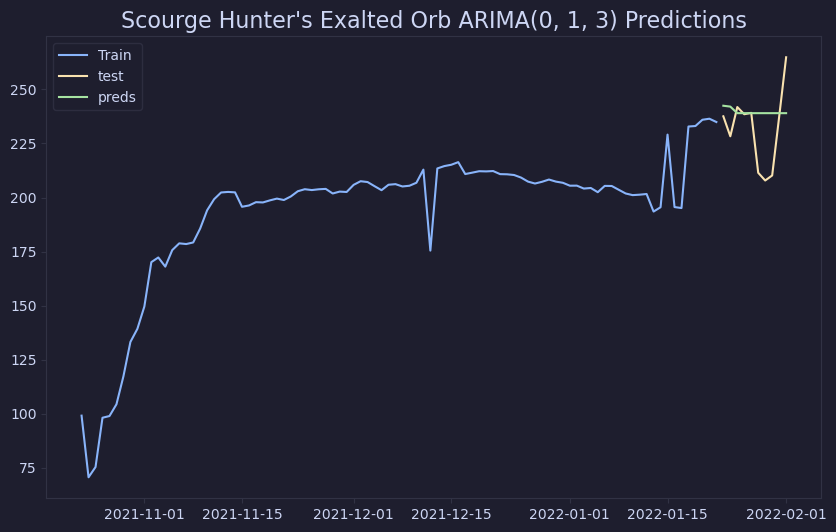


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 551.4506994832457.
The Mean Absolute Error is 23.486678257120357
The Mean Squared Error is 845.0017196108975


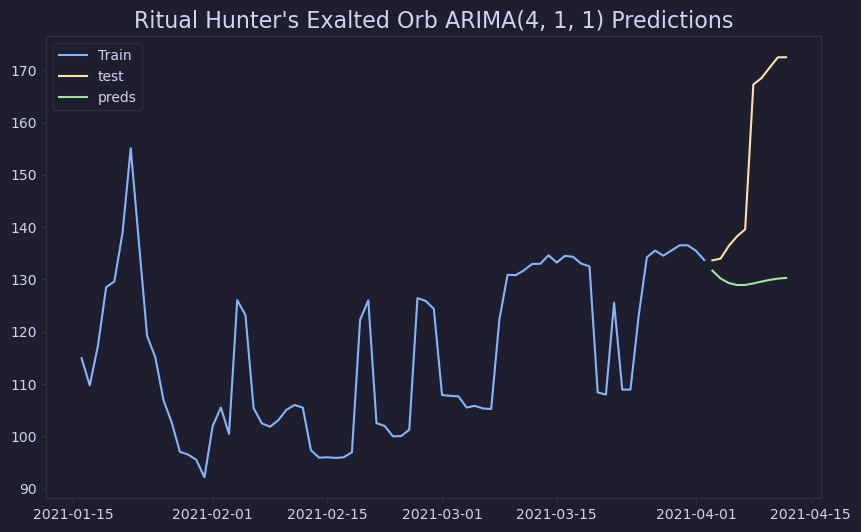


Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 540.7125868161871.
The Mean Absolute Error is 2.312363894196955
The Mean Squared Error is 9.578347618737709


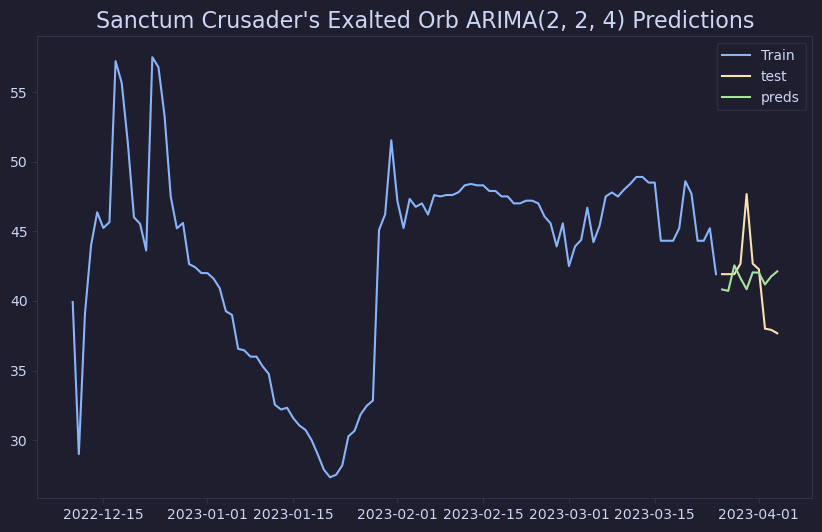


Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 855.053522167525.
The Mean Absolute Error is 2.7478099657249744
The Mean Squared Error is 8.881514510240972


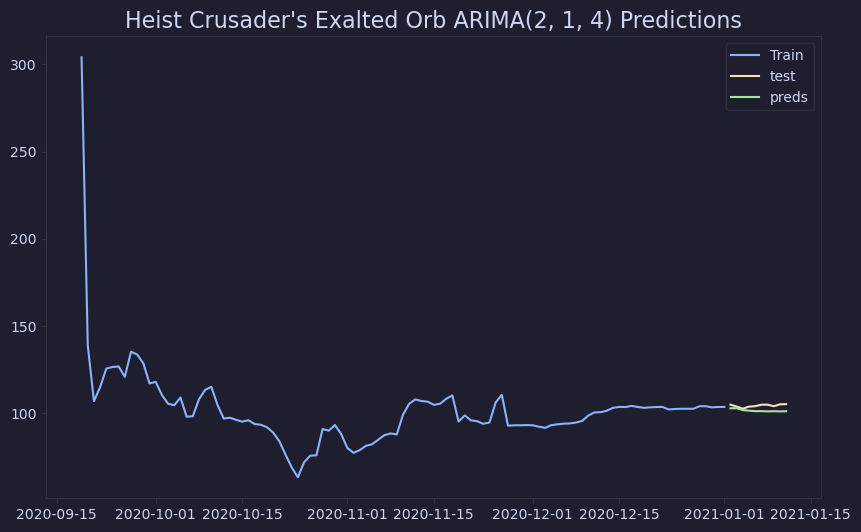


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 679.6942429859132.
The Mean Absolute Error is 120.10410476992834
The Mean Squared Error is 16199.090839935312


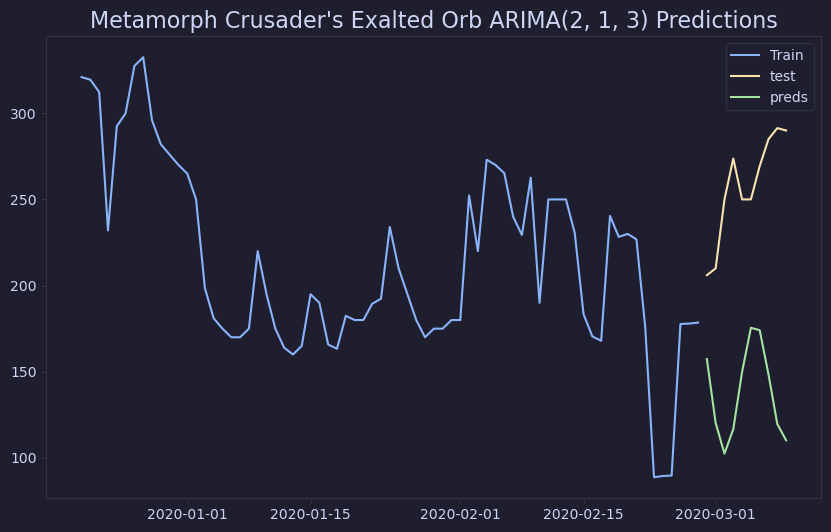


Our model that minimizes AIC on the training data is the ARIMA(0,1,2).
This model has an AIC of 598.0736121007544.
The Mean Absolute Error is 3.5615646881060217
The Mean Squared Error is 16.07323911258136


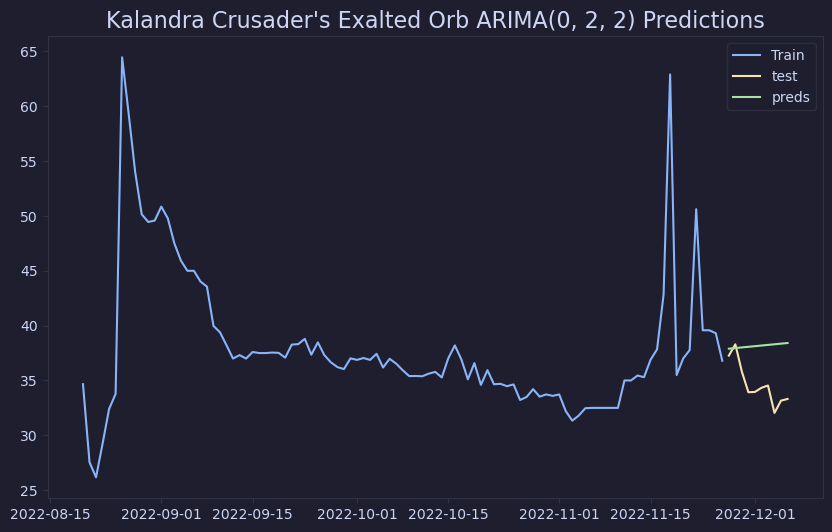


Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 717.4814199887377.
The Mean Absolute Error is 21.30386703976546
The Mean Squared Error is 531.9116388288008


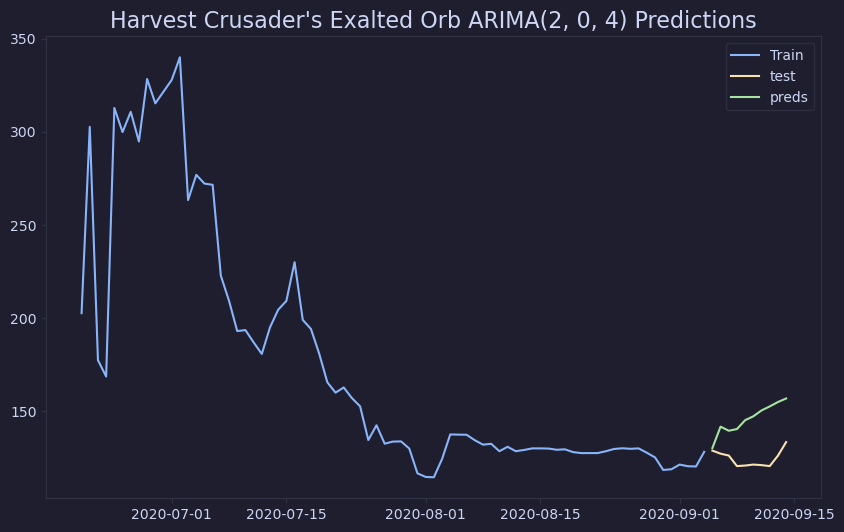


Our model that minimizes AIC on the training data is the ARIMA(4,1,2).
This model has an AIC of 554.3770597589079.
The Mean Absolute Error is 3.347988510649904
The Mean Squared Error is 13.645840834404037


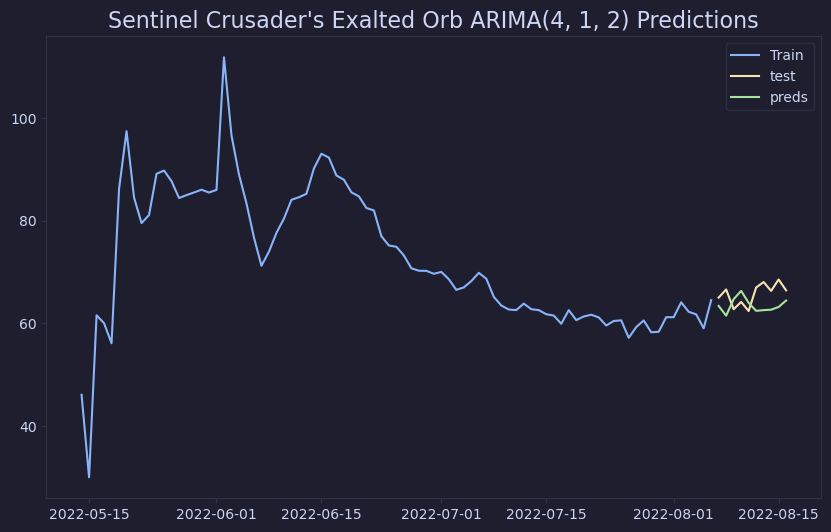


Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of 803.2773221264433.
The Mean Absolute Error is 16.394738040803727
The Mean Squared Error is 297.40495472535804


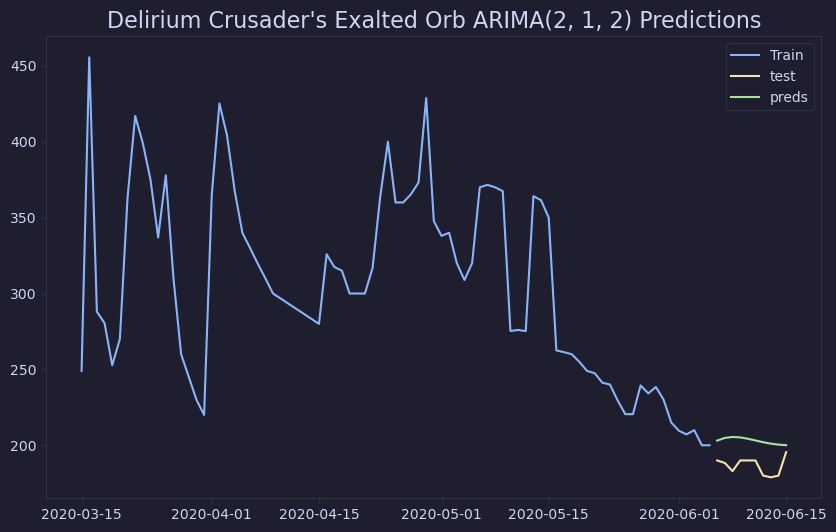


Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of 654.9323652143676.
The Mean Absolute Error is 1.3996908000307784
The Mean Squared Error is 2.804546544427483


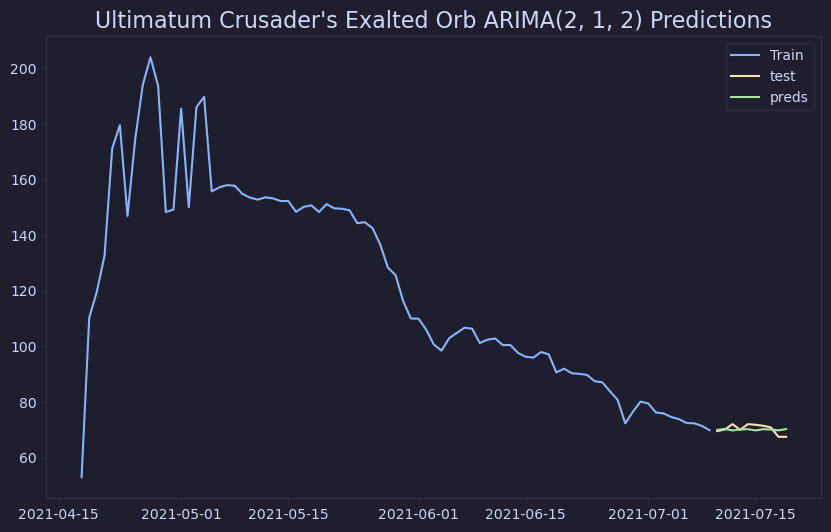


Our model that minimizes AIC on the training data is the ARIMA(4,1,2).
This model has an AIC of 581.9478675864965.
The Mean Absolute Error is 3.497942626899608
The Mean Squared Error is 17.048974336300468


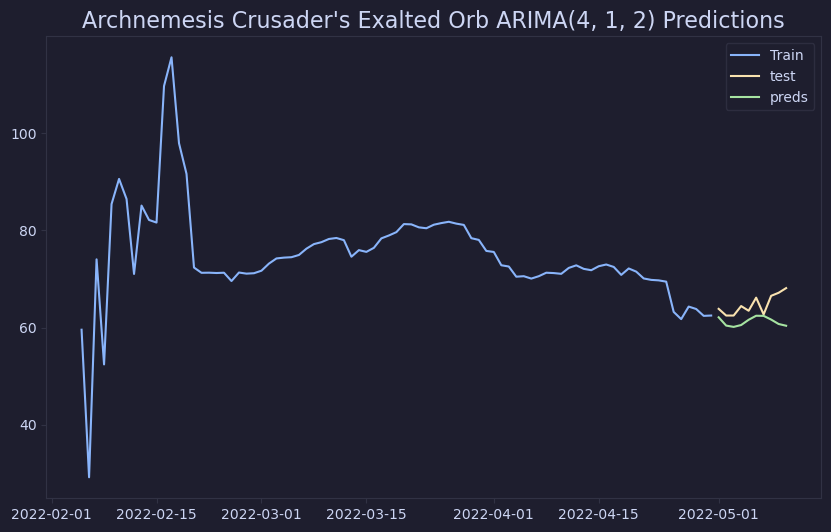


Our model that minimizes AIC on the training data is the ARIMA(4,1,0).
This model has an AIC of 10.0.
The Mean Absolute Error is 27762.797576689434
The Mean Squared Error is 771551857.0351778


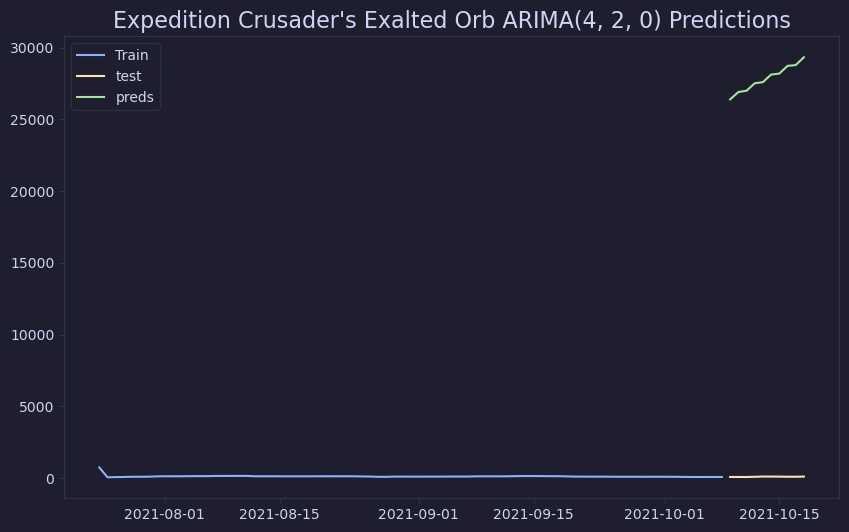


Our model that minimizes AIC on the training data is the ARIMA(3,1,2).
This model has an AIC of 513.6386252895386.
The Mean Absolute Error is 5.594733331596606
The Mean Squared Error is 36.78834263944194


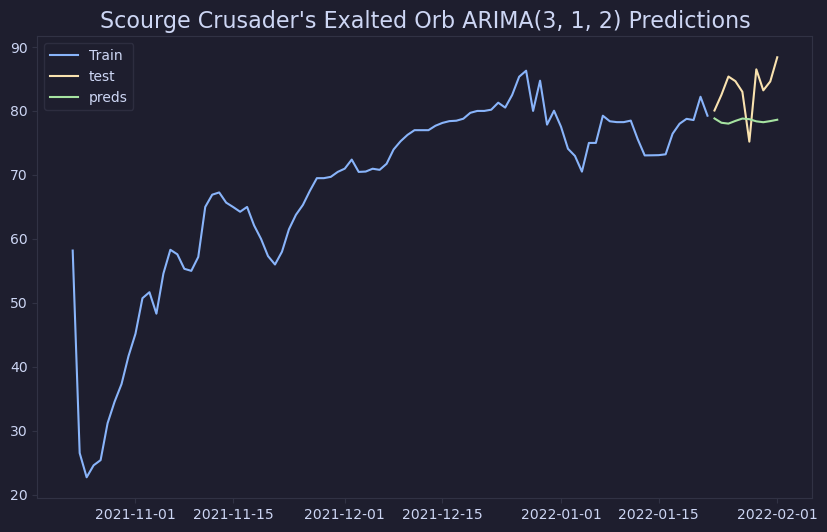


Our model that minimizes AIC on the training data is the ARIMA(4,1,4).
This model has an AIC of 630.0063130400865.
The Mean Absolute Error is 2.351677981331042
The Mean Squared Error is 8.45497325398669


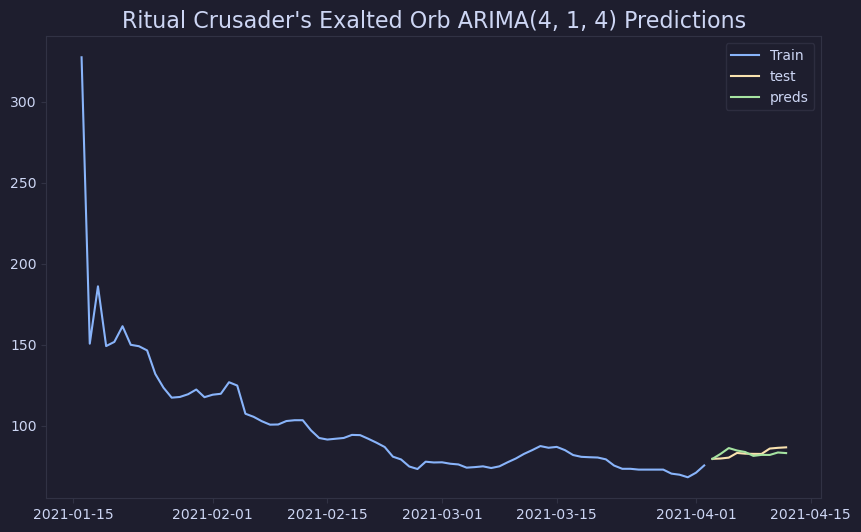


Our model that minimizes AIC on the training data is the ARIMA(3,1,1).
This model has an AIC of 578.435517663096.
The Mean Absolute Error is 4.48917011040111
The Mean Squared Error is 29.07461047631752


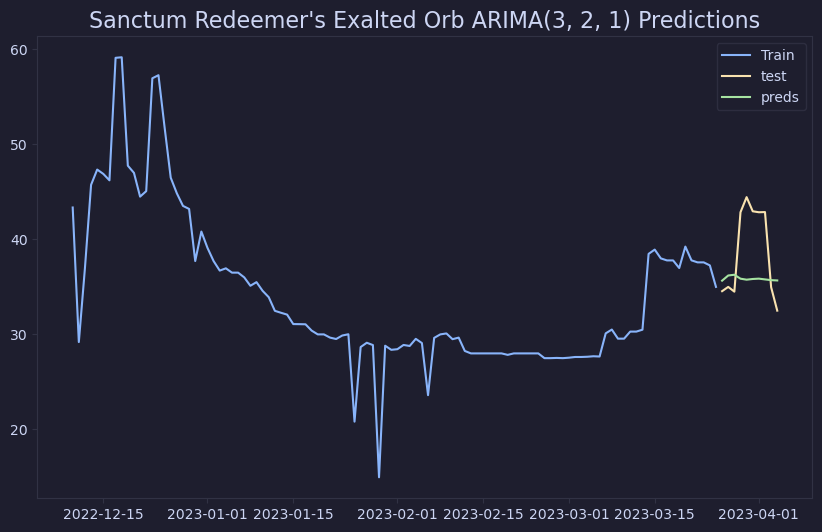


Our model that minimizes AIC on the training data is the ARIMA(3,1,2).
This model has an AIC of 937.300357260888.
The Mean Absolute Error is 3.523298710025787
The Mean Squared Error is 54.57087086617107


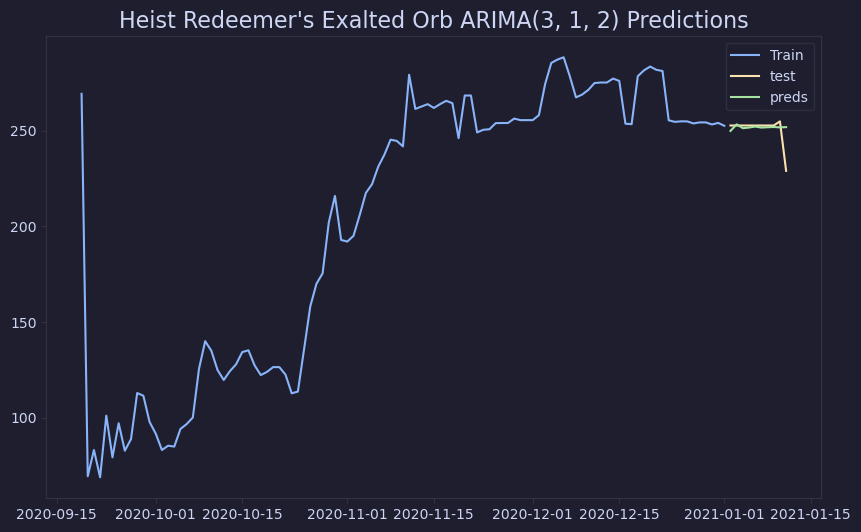


Our model that minimizes AIC on the training data is the ARIMA(1,1,4).
This model has an AIC of 667.0880759427333.
The Mean Absolute Error is 88.91925600447713
The Mean Squared Error is 8774.868860471073


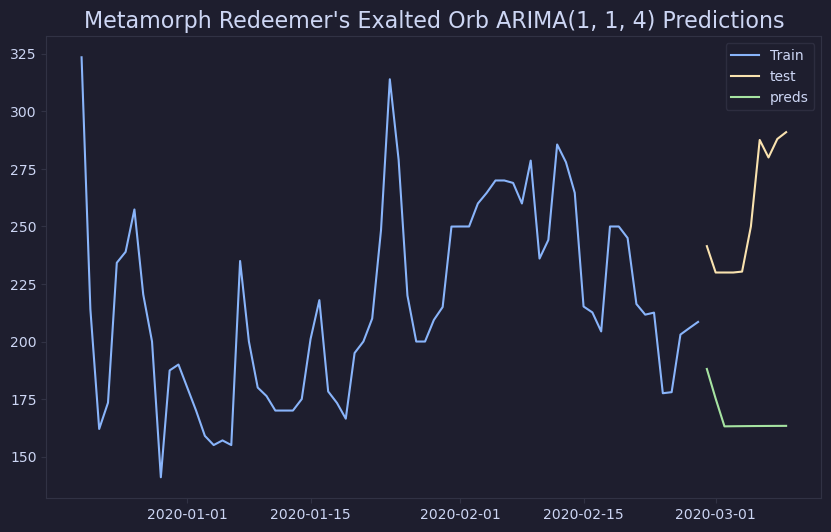


Our model that minimizes AIC on the training data is the ARIMA(2,1,2).
This model has an AIC of 522.9954216975838.
The Mean Absolute Error is 5.663572679462849
The Mean Squared Error is 40.66613585483495


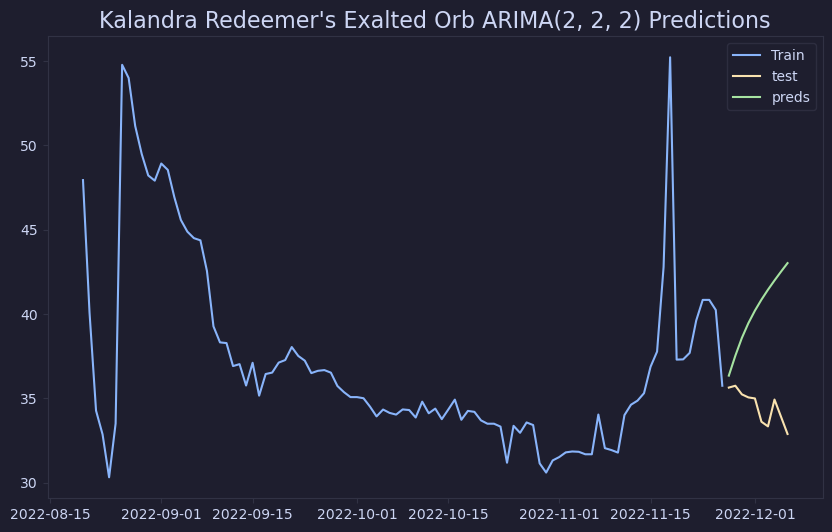


Our model that minimizes AIC on the training data is the ARIMA(4,1,4).
This model has an AIC of 599.7023260634729.
The Mean Absolute Error is 11.380994143844458
The Mean Squared Error is 152.87431051998615


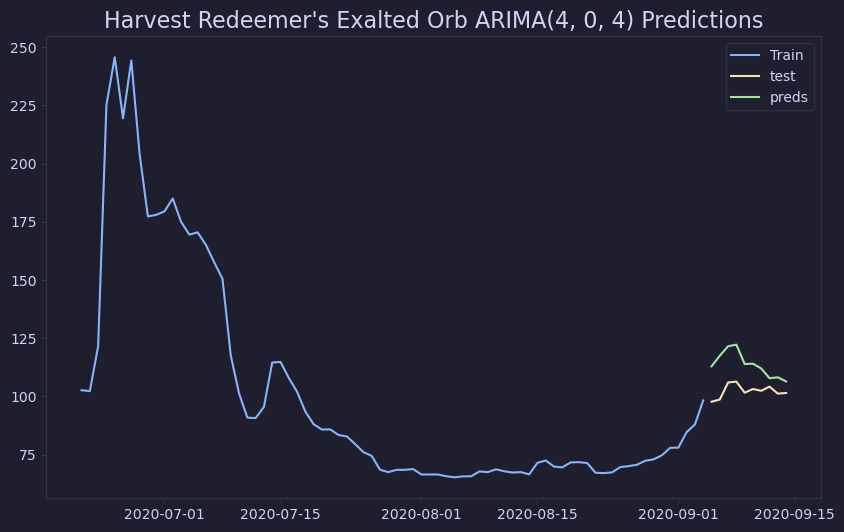


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 533.722405031653.
The Mean Absolute Error is 2.82586693295787
The Mean Squared Error is 12.940975798860347


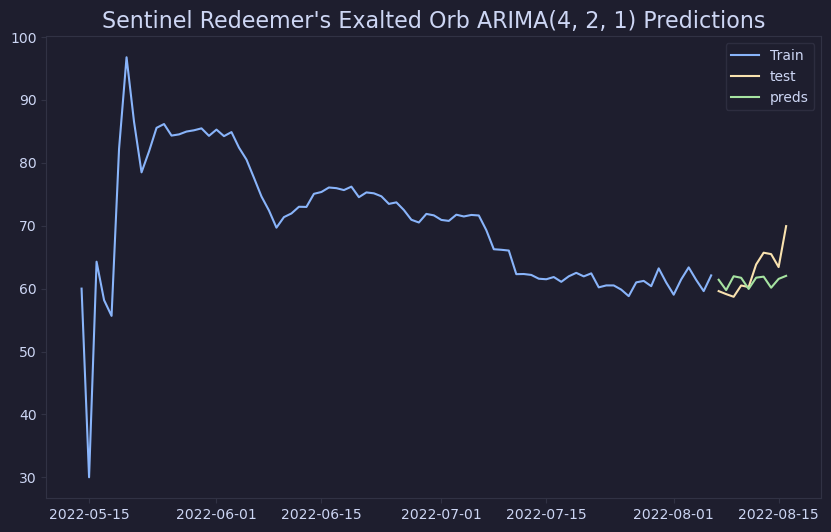


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 733.9896963541652.
The Mean Absolute Error is 8.49082588796089
The Mean Squared Error is 119.87232346018773


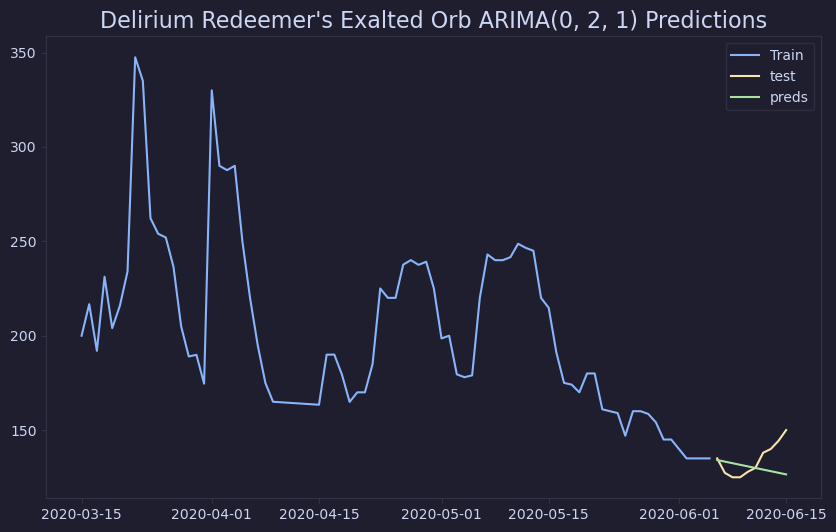


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 646.297144084831.
The Mean Absolute Error is 3.2144719451577117
The Mean Squared Error is 14.635690094424765


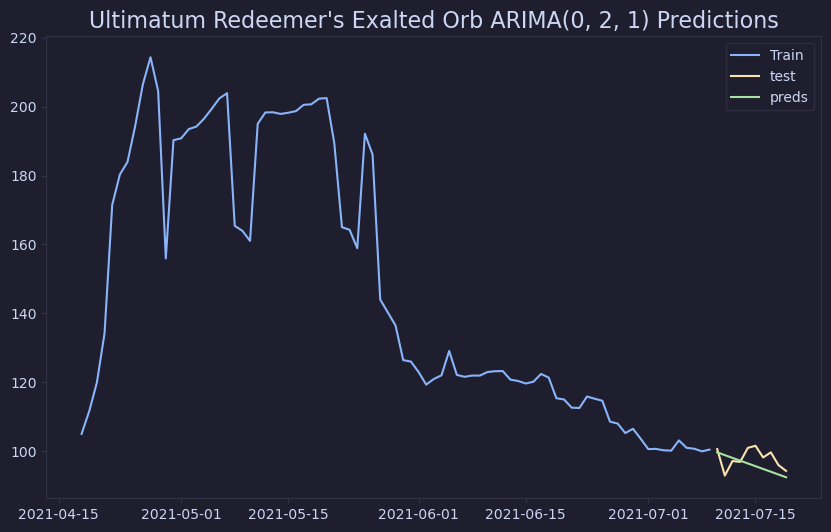


Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 564.7022120006299.
The Mean Absolute Error is 1.9137850512759278
The Mean Squared Error is 6.5922385061204425


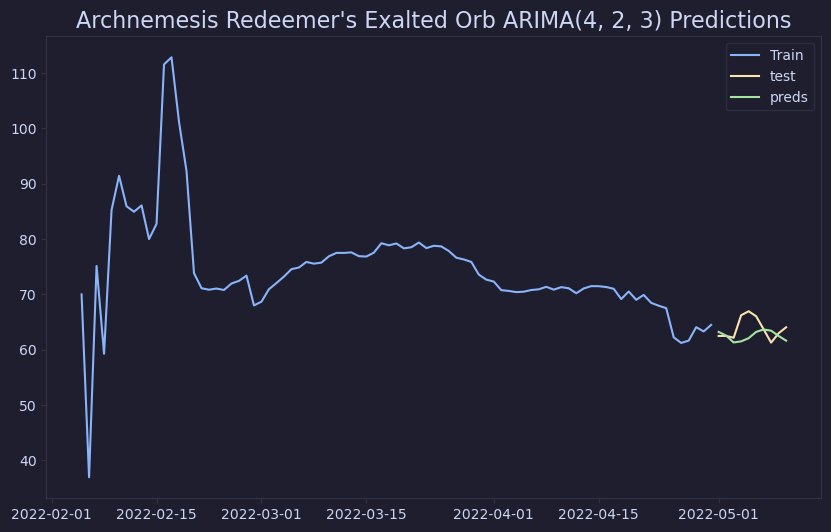


Our model that minimizes AIC on the training data is the ARIMA(1,1,4).
This model has an AIC of 678.8341916722369.
The Mean Absolute Error is 14.182280951148957
The Mean Squared Error is 259.78912727518156


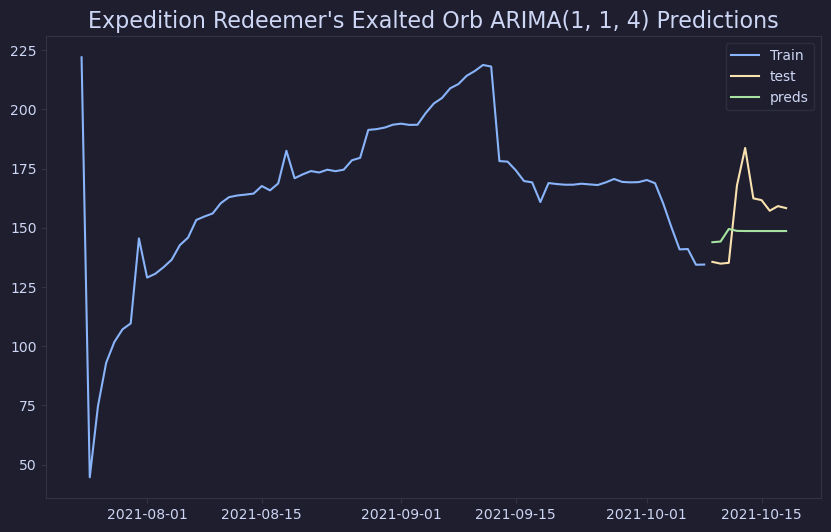


Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 623.4900818182745.
The Mean Absolute Error is 10.793045014800931
The Mean Squared Error is 135.8431900240284


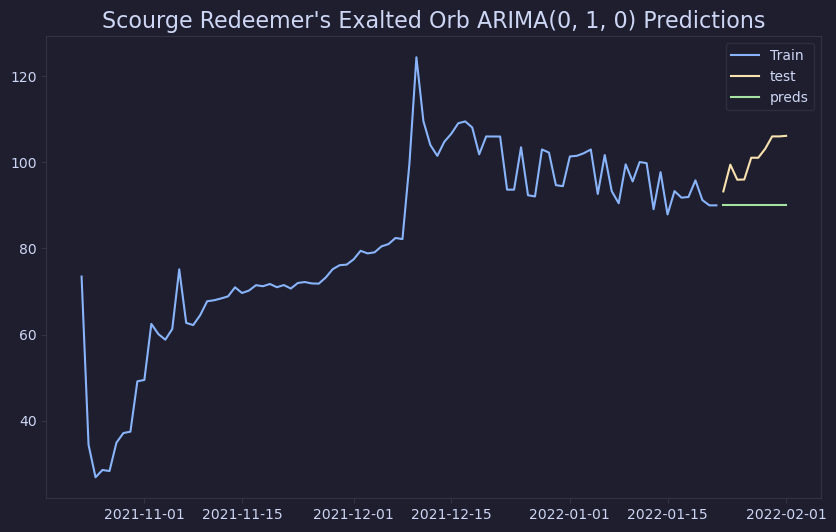


Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 521.773391841471.
The Mean Absolute Error is 28.502233891302968
The Mean Squared Error is 823.9242118530104


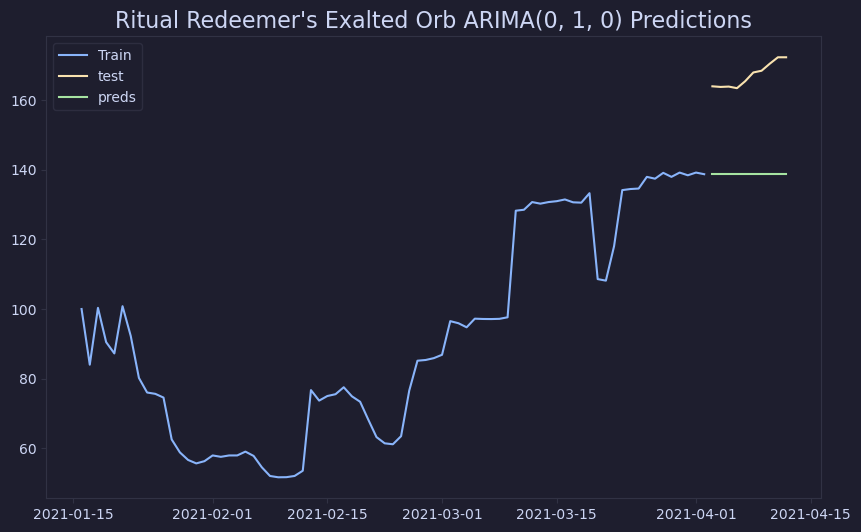


Our model that minimizes AIC on the training data is the ARIMA(3,1,3).
This model has an AIC of 645.1513636283784.
The Mean Absolute Error is 3.0693581373588033
The Mean Squared Error is 17.77518578481659


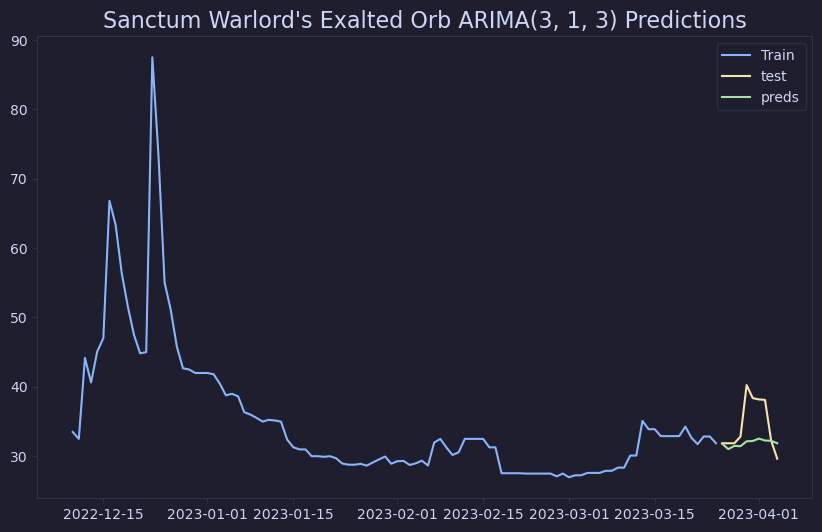


Our model that minimizes AIC on the training data is the ARIMA(1,1,2).
This model has an AIC of 759.5378249972987.
The Mean Absolute Error is 9.387378323265647
The Mean Squared Error is 108.7840958952232


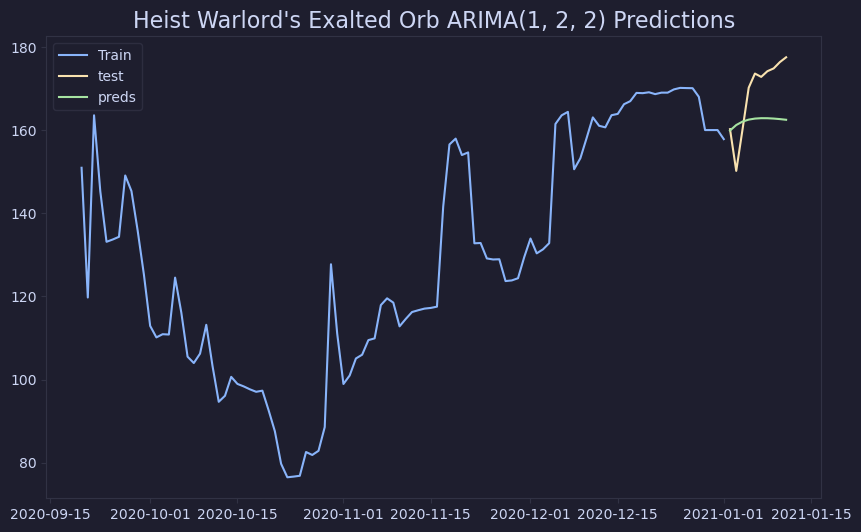


Our model that minimizes AIC on the training data is the ARIMA(1,1,3).
This model has an AIC of 690.6586459787851.
The Mean Absolute Error is 43.35340345849538
The Mean Squared Error is 2646.3561446484996


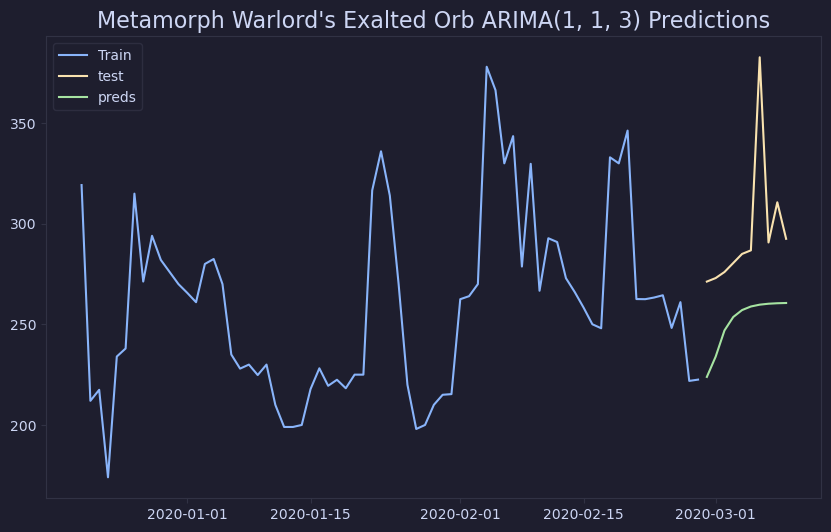


Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 398.9989822972629.
The Mean Absolute Error is 3.0588945096942264
The Mean Squared Error is 11.82954452754067


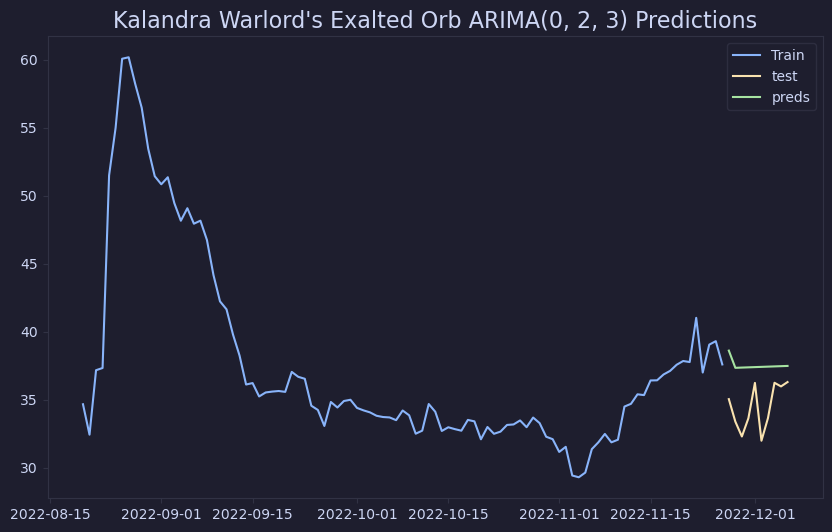


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 626.0235672057422.
The Mean Absolute Error is 9.861036061891827
The Mean Squared Error is 201.99249903959875


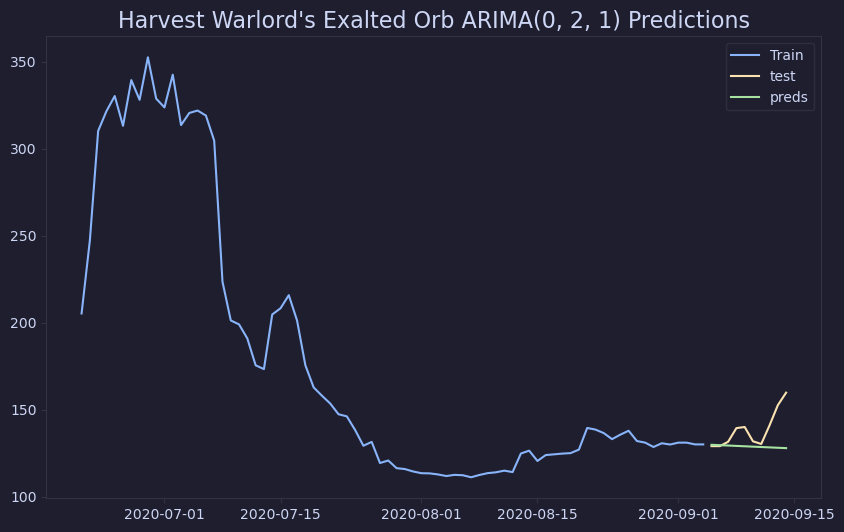


Our model that minimizes AIC on the training data is the ARIMA(2,1,4).
This model has an AIC of 518.7263860058774.
The Mean Absolute Error is 2.4933332323912127
The Mean Squared Error is 10.165132582827079


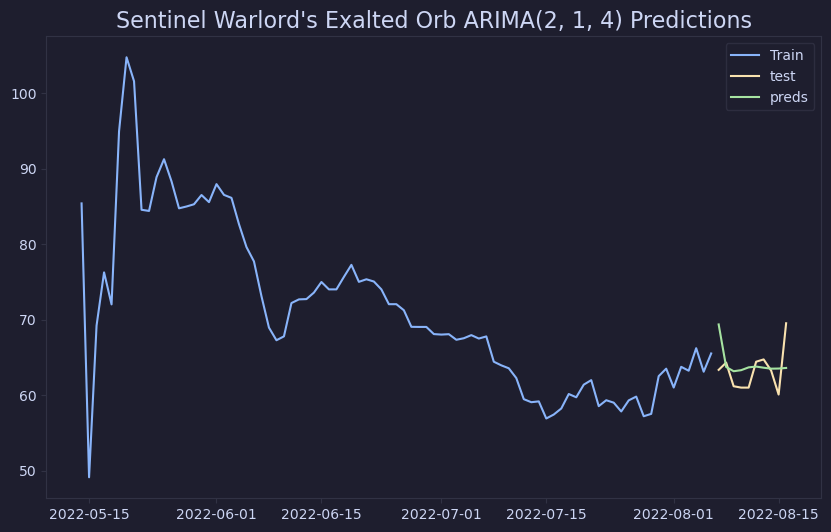


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 800.8931438906478.
The Mean Absolute Error is 18.74160062736548
The Mean Squared Error is 600.4969686764958


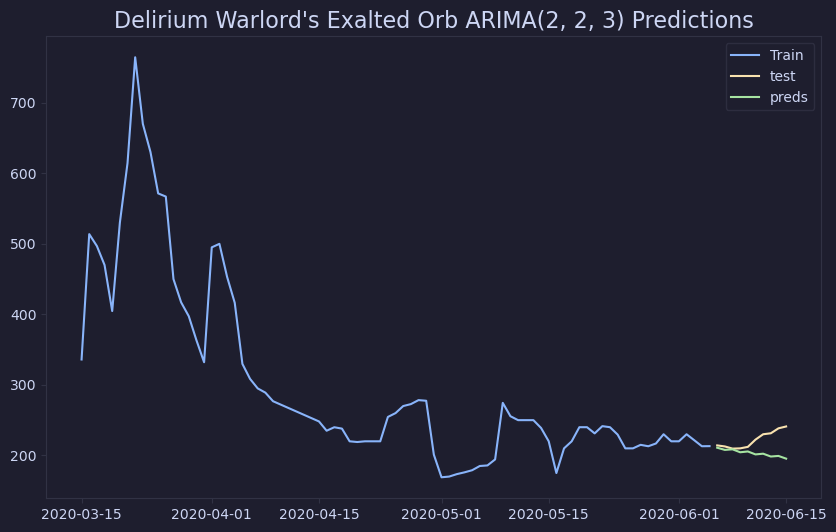


Our model that minimizes AIC on the training data is the ARIMA(3,1,4).
This model has an AIC of 635.5055157368114.
The Mean Absolute Error is 14.982141407899245
The Mean Squared Error is 355.4712286459177


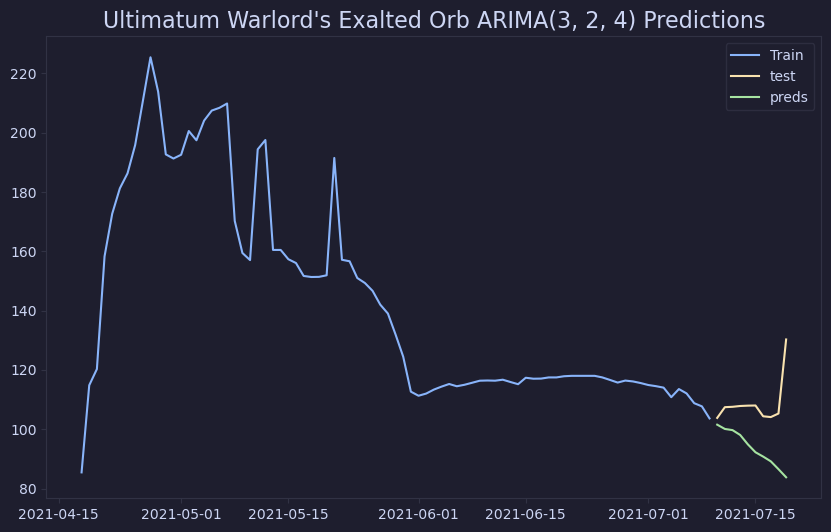


Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 495.46476347790843.
The Mean Absolute Error is 9.73815588870275
The Mean Squared Error is 122.44181174609666


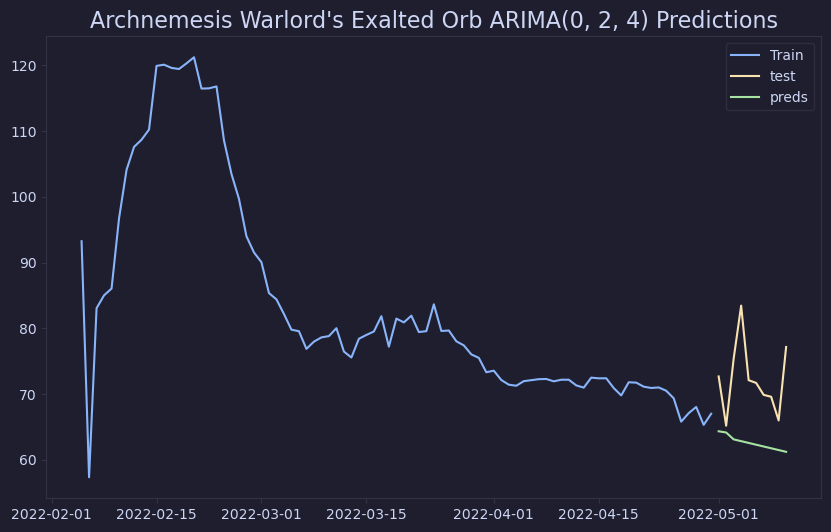


Our model that minimizes AIC on the training data is the ARIMA(4,1,3).
This model has an AIC of 636.7575102524095.
The Mean Absolute Error is 11.523477577902085
The Mean Squared Error is 152.94755995817314


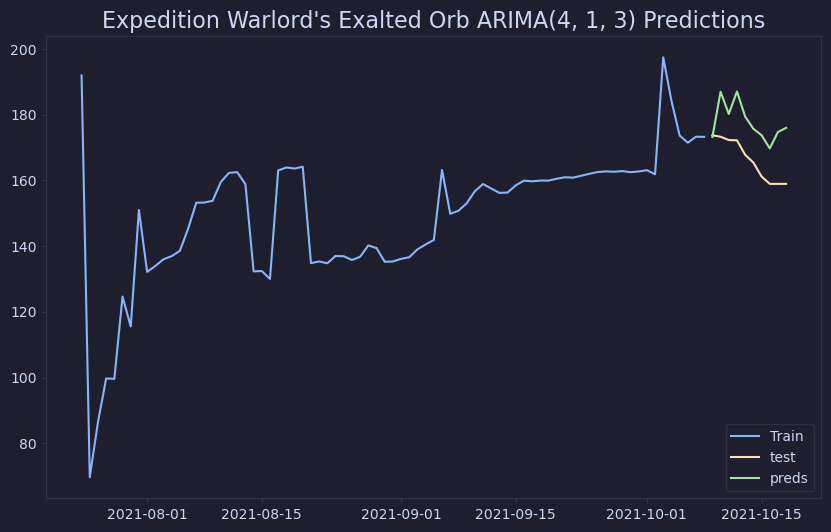


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 642.0567904237123.
The Mean Absolute Error is 23.703256535204055
The Mean Squared Error is 896.1868878993407


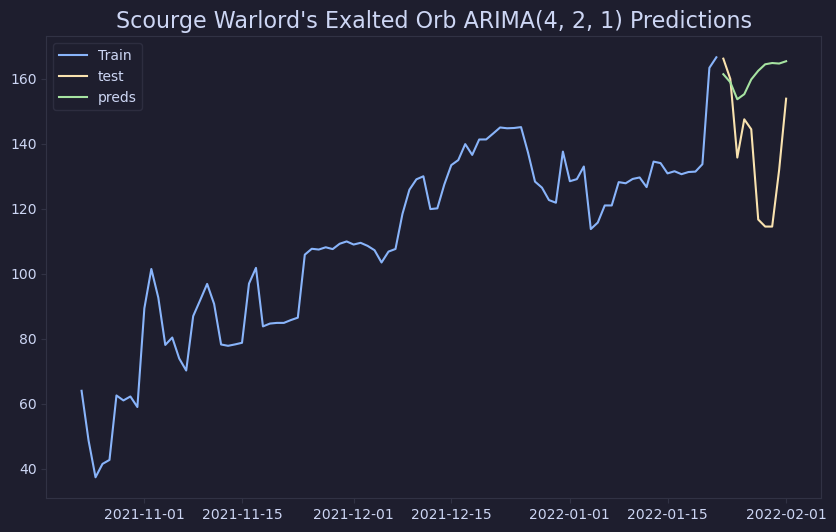


Our model that minimizes AIC on the training data is the ARIMA(3,1,2).
This model has an AIC of 599.8735008954884.
The Mean Absolute Error is 22.626012535487646
The Mean Squared Error is 702.2472509933893


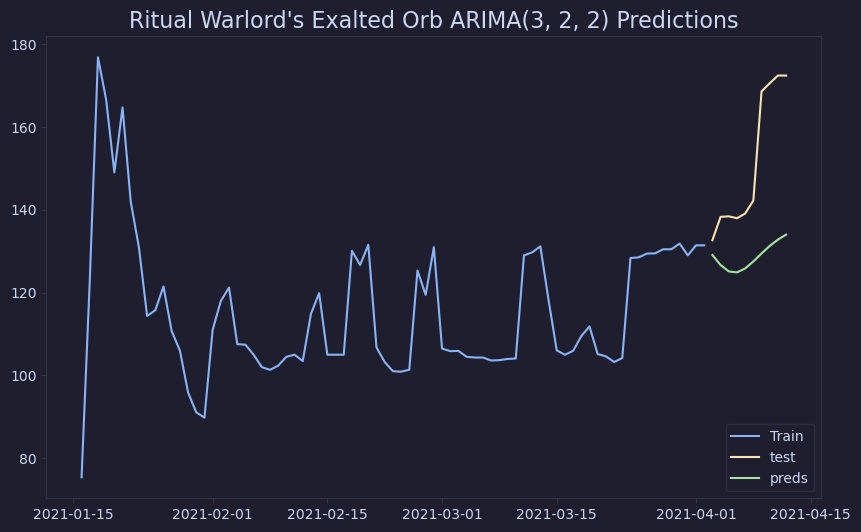


Our model that minimizes AIC on the training data is the ARIMA(3,1,0).
This model has an AIC of 671.554366896786.
The Mean Absolute Error is 6.199366714571767
The Mean Squared Error is 44.17473008618924


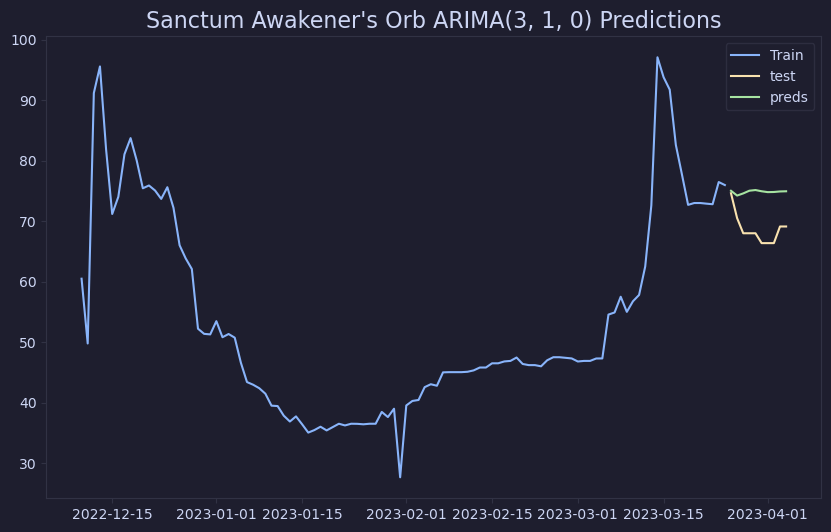


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 923.9858817884956.
The Mean Absolute Error is 8.648829638277107
The Mean Squared Error is 79.46074408514768


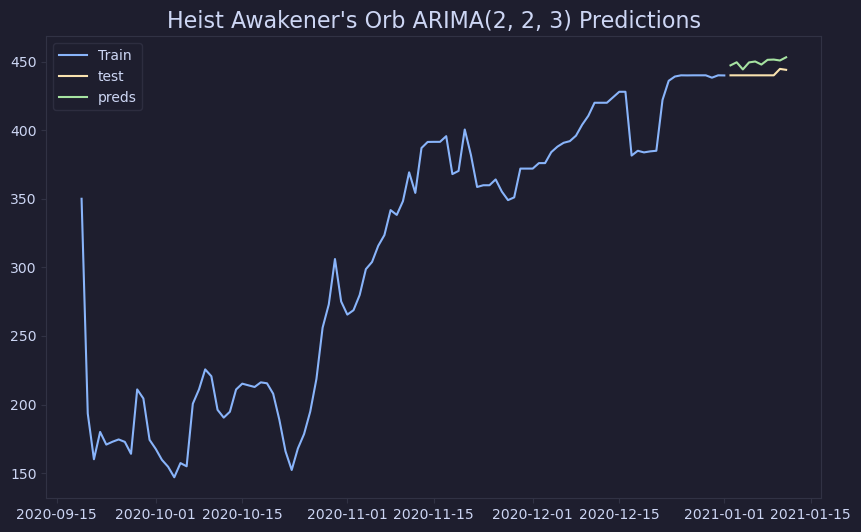


Our model that minimizes AIC on the training data is the ARIMA(1,1,4).
This model has an AIC of 736.3349078714783.
The Mean Absolute Error is 62.621412052173085
The Mean Squared Error is 4462.786615478196


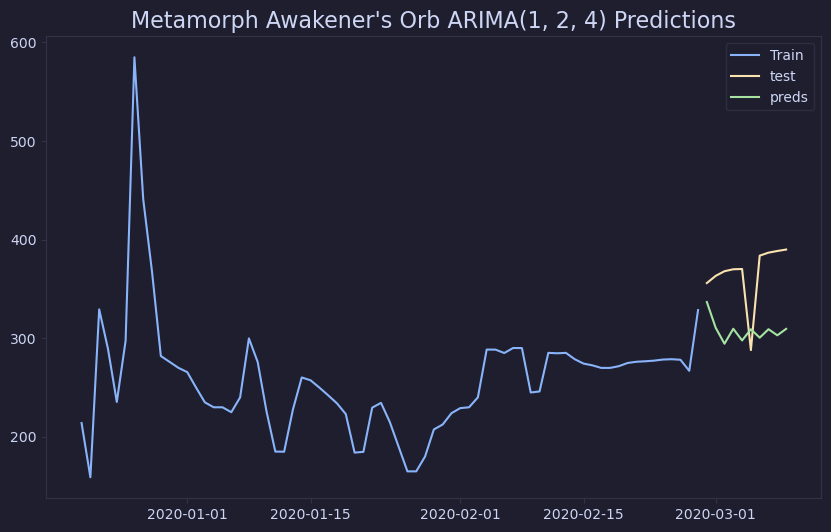


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 643.4107038835743.
The Mean Absolute Error is 10.861813363968064
The Mean Squared Error is 149.62313194380135


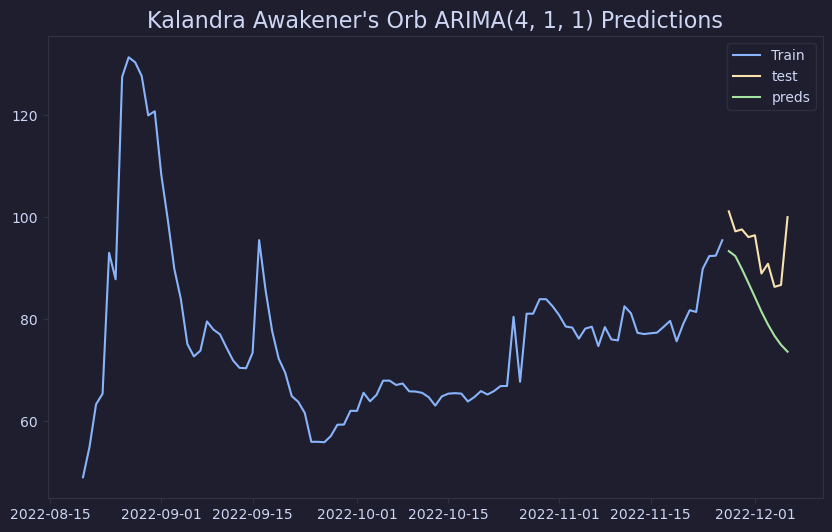


Our model that minimizes AIC on the training data is the ARIMA(4,1,4).
This model has an AIC of 796.8654750873654.
The Mean Absolute Error is 100.30822317491022
The Mean Squared Error is 13688.299555747493


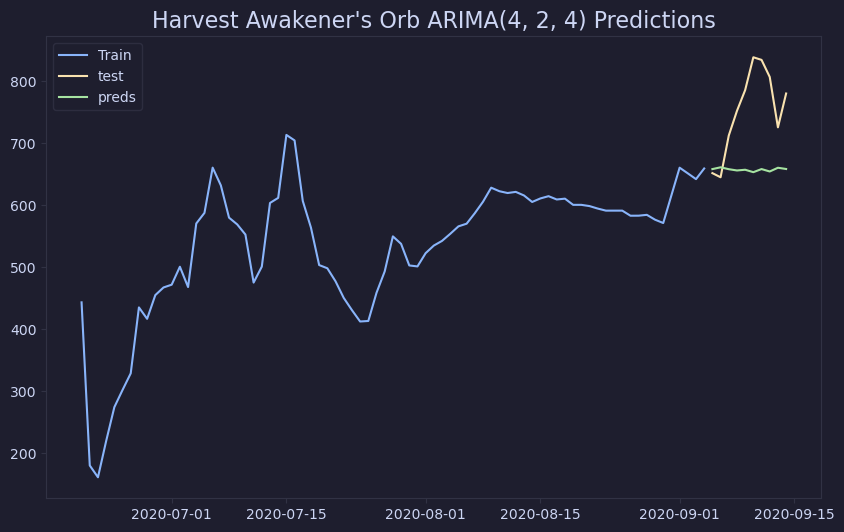


Our model that minimizes AIC on the training data is the ARIMA(0,1,2).
This model has an AIC of 718.2207528670532.
The Mean Absolute Error is 27.477754992352697
The Mean Squared Error is 1113.775381156606


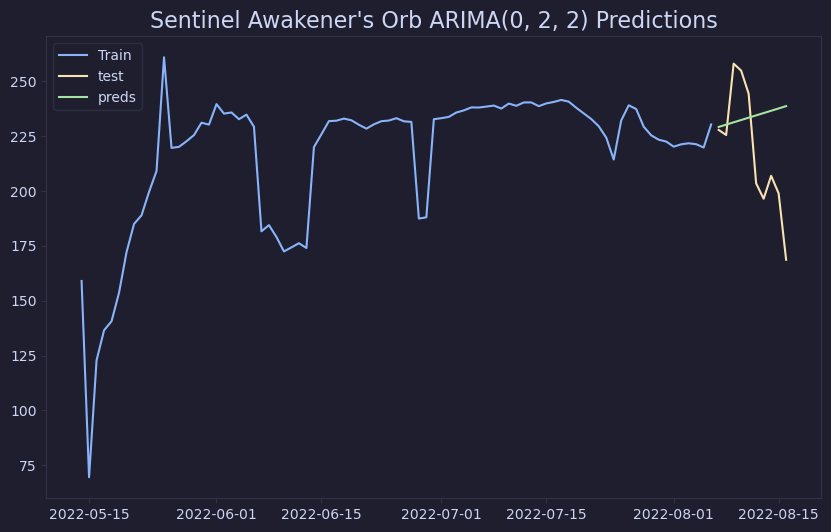


Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of 811.215379418236.
The Mean Absolute Error is 13.862610003913655
The Mean Squared Error is 344.046039333593


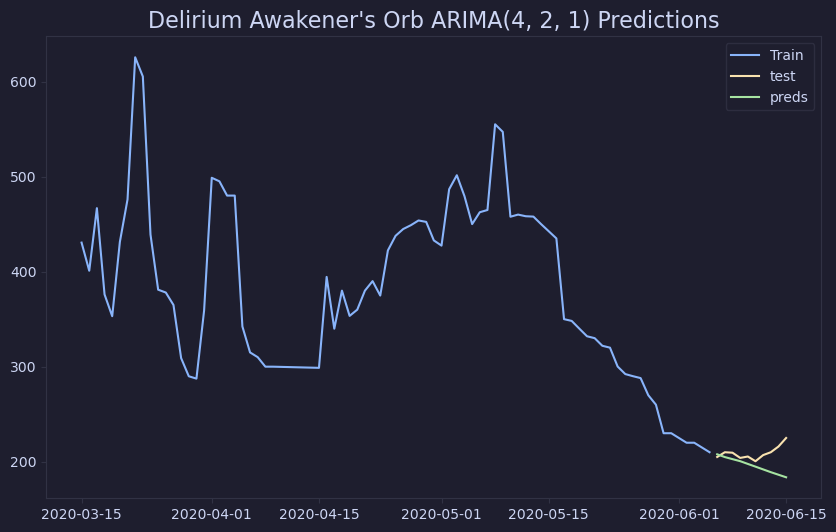


Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 686.2970335883701.
The Mean Absolute Error is 26.591456163419195
The Mean Squared Error is 815.9900667334174


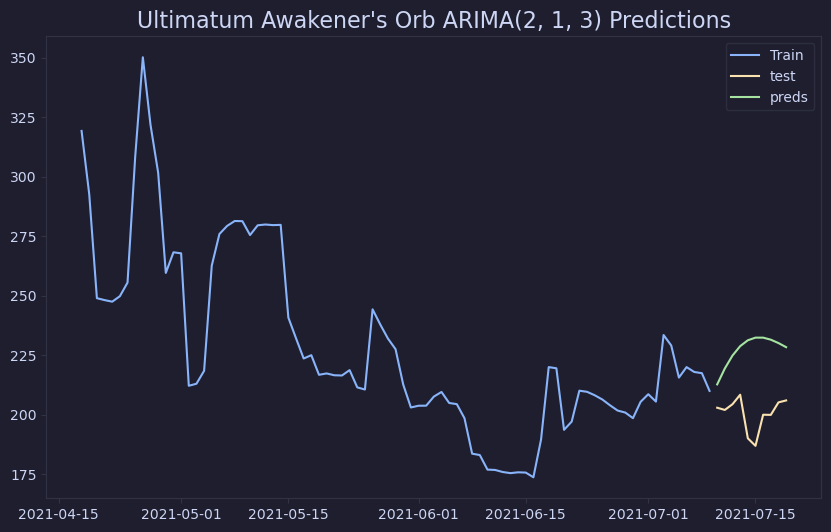


Our model that minimizes AIC on the training data is the ARIMA(1,1,2).
This model has an AIC of 680.3019309564298.
The Mean Absolute Error is 12.66339830724406
The Mean Squared Error is 290.47007886136157


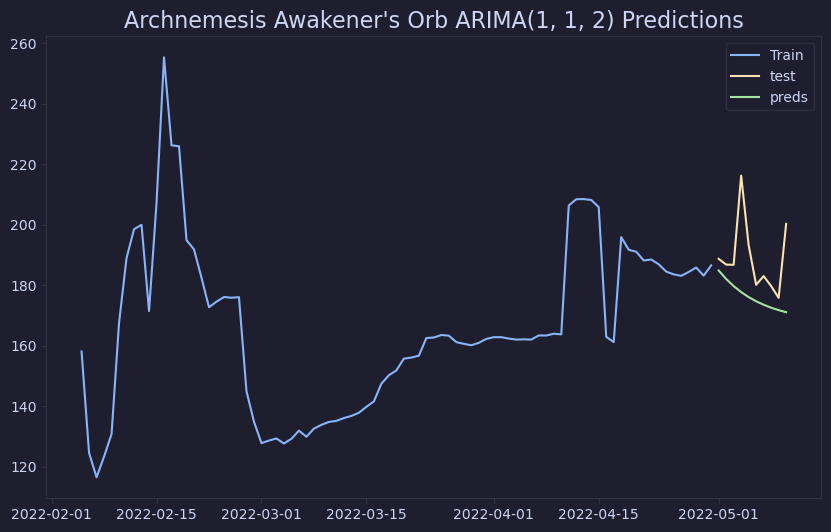


Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
This model has an AIC of 709.9817240498646.
The Mean Absolute Error is 27.775619
The Mean Squared Error is 1257.0997404157897


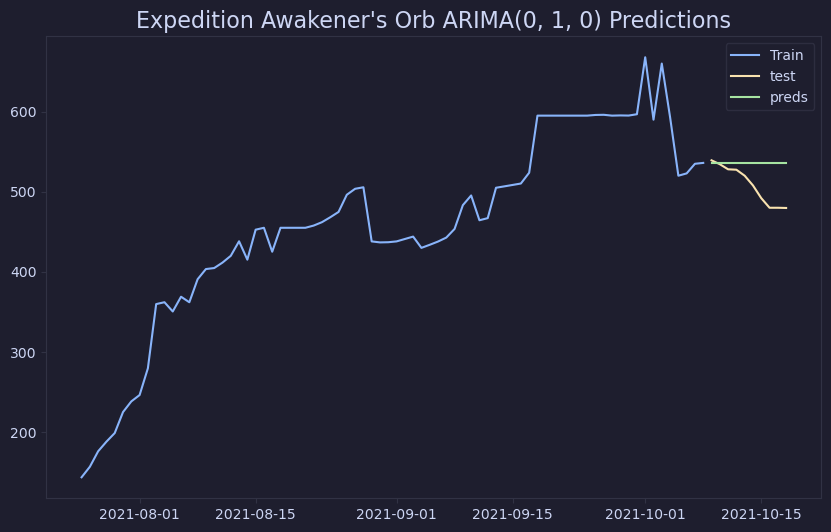


Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 831.8385061041986.
The Mean Absolute Error is 51.47058651826676
The Mean Squared Error is 3373.1221919246104


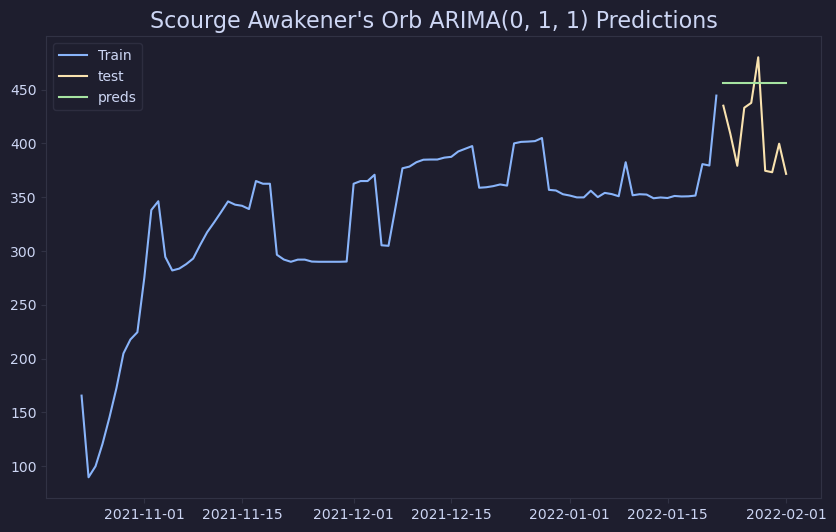


Our model that minimizes AIC on the training data is the ARIMA(0,1,2).
This model has an AIC of 697.7655165449626.
The Mean Absolute Error is 13.793699947862143
The Mean Squared Error is 260.25998329349954


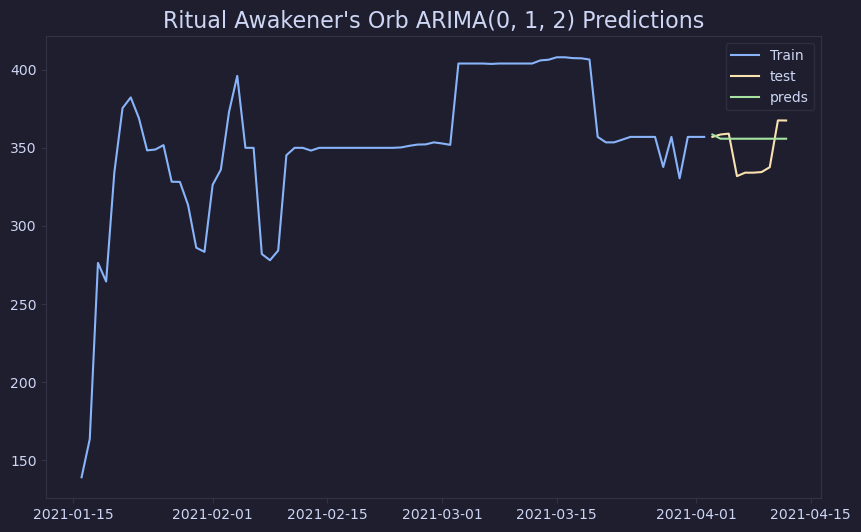

In [13]:
for currency in currencies:
    full_model_proccess(currency)